In [1]:
from lib import data as dat
from lib import handler
from lib import model_methods
import datetime

import logging
logging.getLogger('tensorflow').disabled = True     # Disable Tensorflow warning messages.

import yfinance as yf
import os
import datetime as dt
import shutil
import pandas as pd
import numpy as np

# Define current directory and Database subdirectory.

In [2]:
cwd = os.getcwd()
directory = handler.directories(d = cwd)
db_subdir = directory.location('Data') # Find Database subdirectory location.

# Data Acquisition from Yahoo Finance

In [3]:
stocks_list = ['AAPL', 'MSFT', 'GOOGL', 'GSK', 'AZN', 'PFE']    # Stock list: Apple, Microsoft, Google, GSK, Astra Zeneca, Pfizer.
start_date = dt.datetime(2017, 10, 1)

stocks = dat.data(start = start_date)    # Initiate stock class.

# Get stock data from Yahoo API.
stocks.stocks(database = 'Pre_Covid_Stocks.db', stck = stocks_list, today = False, 
              year = 2019, month = 10, day = 1)

db_output = directory.contents(dir = cwd, pattern = 'Pre_Covid_St', extension = '.db') # Find database output.
filename = os.path.basename(db_output)
slash = directory.OS()  # Operating system.
shutil.move(db_output, db_subdir + slash + filename)    # Move database output to Databases subdirectory.
db_path = directory.contents(dir = db_subdir, pattern = 'Pre_Covid_St', extension = '.db') # Find the new locations of the database.

Connecting to Yahoo Finance...
Fetching AAPL stock data...
[*********************100%***********************]  1 of 1 completed
Adding AAPL data to Pre_Covid_Stocks.db database...
AAPL stock data saved!

Fetching MSFT stock data...
[*********************100%***********************]  1 of 1 completed
Adding MSFT data to Pre_Covid_Stocks.db database...
MSFT stock data saved!

Fetching GOOGL stock data...
[*********************100%***********************]  1 of 1 completed
Adding GOOGL data to Pre_Covid_Stocks.db database...
GOOGL stock data saved!

Fetching GSK stock data...
[*********************100%***********************]  1 of 1 completed
Adding GSK data to Pre_Covid_Stocks.db database...
GSK stock data saved!

Fetching AZN stock data...
[*********************100%***********************]  1 of 1 completed
Adding AZN data to Pre_Covid_Stocks.db database...
AZN stock data saved!

Fetching PFE stock data...
[*********************100%***********************]  1 of 1 completed
Adding PFE 

# SQLite Queries

In [4]:
# Data Query. All SQL tables are added into individual pandas dataframes.
apple = dat.SQLite_Query(db_path, stocks_list[0]) 
microsoft = dat.SQLite_Query(db_path, stocks_list[1])
google = dat.SQLite_Query(db_path, stocks_list[2])
gsk = dat.SQLite_Query(db_path, stocks_list[3])
astra = dat.SQLite_Query(db_path, stocks_list[4])
pfizer = dat.SQLite_Query(db_path, stocks_list[5])


# Data Preprocessing

In [5]:
pred_days = 365 # number of days used for prediction.

apple_preprocessing = model_methods.preprocessing(apple, pred_days)
microsoft_preprocessing = model_methods.preprocessing(microsoft, pred_days) 
google_preprocessing = model_methods.preprocessing(google, pred_days) 
gsk_preprocessing = model_methods.preprocessing(gsk, pred_days) 
astra_preprocessing = model_methods.preprocessing(astra, pred_days) 
pfizer_preprocessing = model_methods.preprocessing(pfizer, pred_days)

percentage_vol = lambda x : round(x, 4) * 100 # Lambda function to calculate volatility.  

# Apple Stock

Training the model...
[*********************100%***********************]  1 of 1 completed


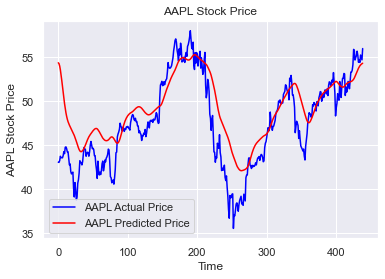

AAPL Stock Adj.Close price prediction (2/10/2019): $54.374817
AAPL Stock Volatility = 27.61%


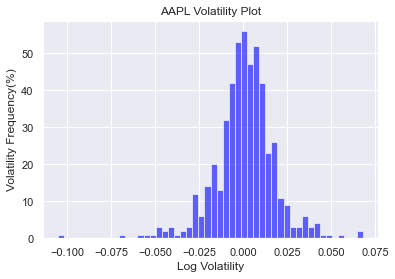

In [6]:
apple_x_train = apple_preprocessing[0]
apple_y_train = apple_preprocessing[1]
apple_scaler = apple_preprocessing[2]

# Training starts.
print('Training the model...')
AAPL_model = model_methods.CNN_model(apple_x_train, apple_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2018, 1, 1)
test_end = dt.datetime(2019, 10, 1)
apple_test_data = yf.download(tickers = stocks_list[0], start = test_start, end = test_end) # Get test data from Yahoo.
apple_actual_prices = apple_test_data['Close'].values   # Get closing stock prices.

apple_dataset = pd.concat((apple['Close'], apple_test_data['Close']), axis = 0)
apple_model_inputs = apple_dataset[len(apple_dataset) - len(apple_test_data) - pred_days:].values
apple_model_inputs = apple_model_inputs.reshape(-1, 1)
apple_model_inputs = apple_scaler.transform(apple_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
apple_x_test = model_methods.test_preprocessing(pred_days, apple_model_inputs)
apple_pred_prices = AAPL_model.predict(apple_x_test, verbose = 0)
apple_pred_prices = apple_scaler.inverse_transform(apple_pred_prices)

# Plot Results
model_methods.plot_data(name = stocks_list[0], type = 'Stock', actual = apple_actual_prices, predicted = apple_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = apple_model_inputs, name = stocks_list[0], type = 'Stock', prediction_days = pred_days, 
                                model = AAPL_model, scaler = apple_scaler, today = False, year = 2019, month = 10, day = 2)

# Volatility
apple_copy = apple.copy()   # Copy of dataframe to add a new column for volatility.
apple_copy['Log returns'] = np.log(apple['Close']/apple['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
aaple_returns = apple_copy['Log returns']
aaple_returns.std()
apple_volatility = aaple_returns.std()*252**.5   # 255 is the trading days per annum. **.5 is square root.
volat = str(percentage_vol(apple_volatility))
model_methods.plot_volatility(apple_copy['Log returns'], volat, name = stocks_list[0])
print('%s Stock Volatility = %s%%' %(stocks_list[0], volat))

# Microsoft Stock

Training the model...
[*********************100%***********************]  1 of 1 completed


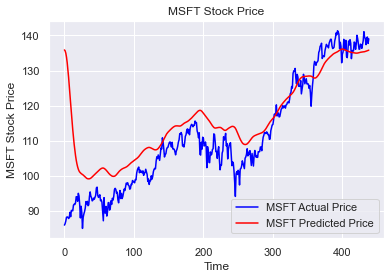

MSFT Stock Adj.Close price prediction (2/10/2019): $135.873260
MSFT Stock Volatility = 24.86%


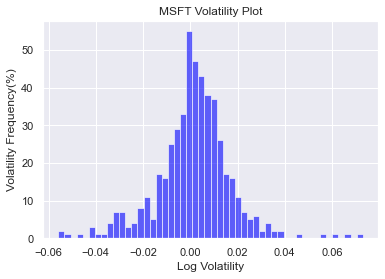

In [7]:
microsoft_x_train = microsoft_preprocessing[0]
microsoft_y_train = microsoft_preprocessing[1]
microsoft_scaler = microsoft_preprocessing[2]

# Training starts.
print('Training the model...')
MSFT_model = model_methods.CNN_model(microsoft_x_train, microsoft_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2018, 1, 1)
test_end = dt.datetime(2019, 10, 1)
microsoft_test_data = yf.download(tickers = stocks_list[1], start = test_start, end = test_end) # Get test data from Yahoo.
microsoft_actual_prices = microsoft_test_data['Close'].values # Get closing stock prices.

microsoft_dataset = pd.concat((microsoft['Close'], microsoft_test_data['Close']), axis = 0)
microsoft_model_inputs = microsoft_dataset[len(microsoft_dataset) - len(microsoft_test_data) - pred_days:].values
microsoft_model_inputs = microsoft_model_inputs.reshape(-1, 1)
microsoft_model_inputs = microsoft_scaler.transform(microsoft_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
microsoft_x_test = model_methods.test_preprocessing(pred_days, microsoft_model_inputs)
microsoft_pred_prices = MSFT_model.predict(microsoft_x_test, verbose = 0)
microsoft_pred_prices = microsoft_scaler.inverse_transform(microsoft_pred_prices)

# Plot Results
model_methods.plot_data(name = stocks_list[1], type = 'Stock', actual = microsoft_actual_prices, predicted = microsoft_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = microsoft_model_inputs, name = stocks_list[1], type = 'Stock', prediction_days = pred_days, 
                                model = MSFT_model, scaler = microsoft_scaler, today = False, year = 2019, month = 10, day = 2)

# Volatility
microsoft_copy = microsoft.copy()   # Copy of dataframe to add a new column for volatility.
microsoft_copy['Log returns'] = np.log(microsoft['Close']/microsoft['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
ms_returns = microsoft_copy['Log returns']
ms_returns.std()
microsoft_volatility = ms_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(microsoft_volatility))
model_methods.plot_volatility(ms_returns, volat, name = stocks_list[1])
print('%s Stock Volatility = %s%%' %(stocks_list[1], volat))

# Google Stock

Training the model...
[*********************100%***********************]  1 of 1 completed


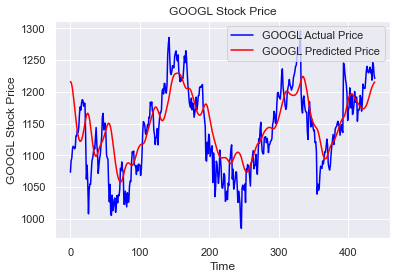

GOOGL Stock Adj.Close price prediction (2/10/2019): $1216.148071
GOOGL Stock Volatility = 26.169999999999998%


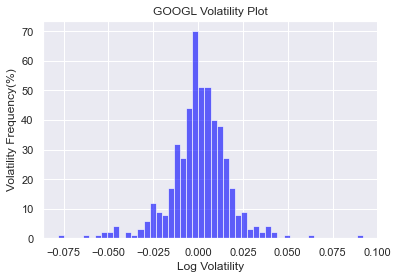

In [8]:
google_x_train = google_preprocessing[0]
google_y_train = google_preprocessing[1]
google_scaler = google_preprocessing[2]

# Training starts.
print('Training the model...')
GOOGL_model = model_methods.CNN_model(google_x_train, google_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2018, 1, 1)
test_end = dt.datetime(2019, 10, 1)
google_test_data = yf.download(tickers = stocks_list[2], start = test_start, end = test_end) # Get test data from Yahoo.
google_actual_prices = google_test_data['Close'].values # Get closing stock prices.

google_dataset = pd.concat((google['Close'], google_test_data['Close']), axis = 0)
google_model_inputs = google_dataset[len(google_dataset) - len(google_test_data) - pred_days:].values
google_model_inputs = google_model_inputs.reshape(-1, 1)
google_model_inputs = google_scaler.transform(google_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
google_x_test = model_methods.test_preprocessing(pred_days, google_model_inputs)
google_pred_prices = GOOGL_model.predict(google_x_test, verbose = 0)
google_pred_prices = google_scaler.inverse_transform(google_pred_prices)

# Plot Results
model_methods.plot_data(name = stocks_list[2], type = 'Stock', actual = google_actual_prices, predicted = google_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = google_model_inputs, name = stocks_list[2], type = 'Stock', prediction_days = pred_days, 
                                model = GOOGL_model, scaler = google_scaler, today = False, year = 2019, month = 10, day = 2)

# Volatility
google_copy = google.copy()   # Copy of dataframe to add a new column for volatility.
google_copy['Log returns'] = np.log(google['Close']/google['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
google_returns = google_copy['Log returns']
google_returns.std()
google_volatility = google_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(google_volatility))
model_methods.plot_volatility(google_copy['Log returns'], volat, name = stocks_list[2])
print('%s Stock Volatility = %s%%' %(stocks_list[2], volat))

# GSK Stock

Training the model...
[*********************100%***********************]  1 of 1 completed


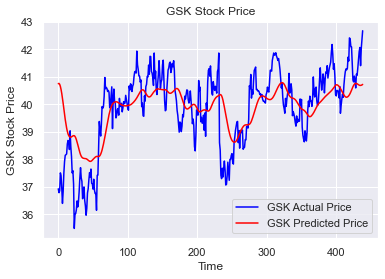

GSK Stock Adj.Close price prediction (2/10/2019): $40.756493
GSK Stock Volatility = 17.95%


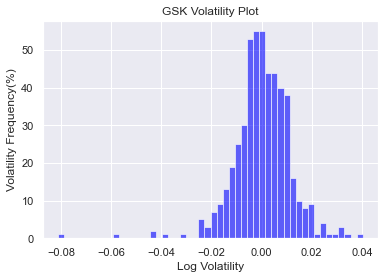

In [9]:
gsk_x_train = gsk_preprocessing[0]
gsk_y_train = gsk_preprocessing[1]
gsk_scaler = gsk_preprocessing[2]

# Training starts.
print('Training the model...')
GSK_model = model_methods.CNN_model(gsk_x_train, gsk_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2018, 1, 1)
test_end = dt.datetime(2019, 10, 1)
gsk_test_data = yf.download(tickers = stocks_list[3], start = test_start, end = test_end) # Get test data from Yahoo.
gsk_actual_prices = gsk_test_data['Close'].values # Get closing stock prices.

gsk_dataset = pd.concat((gsk['Close'], gsk_test_data['Close']), axis = 0)
gsk_model_inputs = gsk_dataset[len(gsk_dataset) - len(gsk_test_data) - pred_days:].values
gsk_model_inputs = gsk_model_inputs.reshape(-1, 1)
gsk_model_inputs = gsk_scaler.transform(gsk_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
gsk_x_test = model_methods.test_preprocessing(pred_days, gsk_model_inputs)
gsk_pred_prices = GSK_model.predict(gsk_x_test, verbose = 0)
gsk_pred_prices = gsk_scaler.inverse_transform(gsk_pred_prices)

# Plot Results
model_methods.plot_data(name = stocks_list[3], type = 'Stock', actual = gsk_actual_prices, predicted = gsk_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = gsk_model_inputs, name = stocks_list[3], type = 'Stock', prediction_days = pred_days, 
                                model = GSK_model, scaler = gsk_scaler, today = False, year = 2019, month = 10, day = 2)

# Volatility
gsk_copy = gsk.copy()   # Copy of dataframe to add a new column for volatility.
gsk_copy['Log returns'] = np.log(gsk['Close']/gsk['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
gsk_returns = gsk_copy['Log returns']
gsk_returns.std()
gsk_volatility = gsk_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(gsk_volatility))
model_methods.plot_volatility(gsk_copy['Log returns'], volat, name = stocks_list[3])
print('%s Stock Volatility = %s%%' %(stocks_list[3], volat))

# Astra Zeneca Stock

Training the model...
[*********************100%***********************]  1 of 1 completed


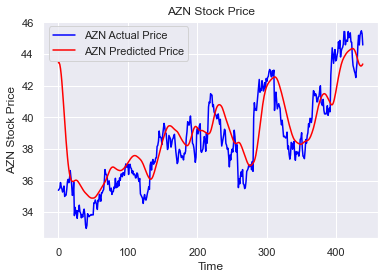

AZN Stock Adj.Close price prediction (2/10/2019): $43.453655
AZN Stock Volatility = 19.91%


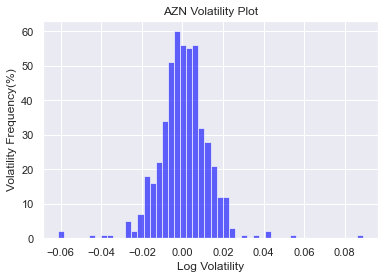

In [10]:
astra_x_train = astra_preprocessing[0]
astra_y_train = astra_preprocessing[1]
astra_scaler = astra_preprocessing[2]

# Training starts.
print('Training the model...')
AZN_model = model_methods.CNN_model(astra_x_train, astra_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2018, 1, 1)
test_end = dt.datetime(2019, 10, 1)
astra_test_data = yf.download(tickers = stocks_list[4], start = test_start, end = test_end) # Get test data from Yahoo.
astra_actual_prices = astra_test_data['Close'].values # Get closing stock prices.

astra_dataset = pd.concat((astra['Close'], astra_test_data['Close']), axis = 0)
astra_model_inputs = astra_dataset[len(astra_dataset) - len(astra_test_data) - pred_days:].values
astra_model_inputs = astra_model_inputs.reshape(-1, 1)
astra_model_inputs = astra_scaler.transform(astra_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
astra_x_test = model_methods.test_preprocessing(pred_days, astra_model_inputs)
astra_pred_prices = AZN_model.predict(astra_x_test, verbose = 0)
astra_pred_prices = astra_scaler.inverse_transform(astra_pred_prices)

# Plot Results
model_methods.plot_data(name = stocks_list[4], type = 'Stock', actual = astra_actual_prices, predicted = astra_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = astra_model_inputs, name = stocks_list[4], type = 'Stock', prediction_days = pred_days, 
                                model = AZN_model, scaler = astra_scaler, today = False, year = 2019, month = 10, day = 2)

# Volatility
astra_copy = astra.copy()   # Copy of dataframe to add a new column for volatility.
astra_copy['Log returns'] = np.log(astra['Close']/astra['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
astra_returns = astra_copy['Log returns']
astra_returns.std()
astra_volatility = astra_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(astra_volatility))
model_methods.plot_volatility(astra_copy['Log returns'], volat, name = stocks_list[4])
print('%s Stock Volatility = %s%%' %(stocks_list[4], volat))

# Pfizer Stock

Training the model...
[*********************100%***********************]  1 of 1 completed


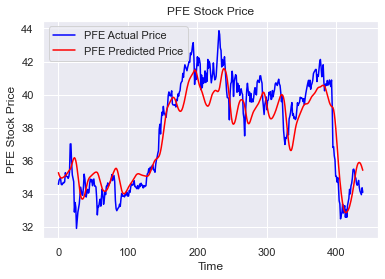

PFE Stock Adj.Close price prediction (2/10/2019): $35.278542
PFE Stock Volatility = 19.09%


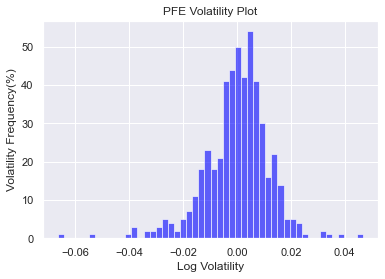

In [11]:
pfizer_x_train = pfizer_preprocessing[0]
pfizer_y_train = pfizer_preprocessing[1]
pfizer_scaler = pfizer_preprocessing[2]

# Training starts.
print('Training the model...')
PFE_model = model_methods.CNN_model(pfizer_x_train, pfizer_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2018, 1, 1)
test_end = dt.datetime(2019, 10, 1)
pfizer_test_data = yf.download(tickers = stocks_list[5], start = test_start, end = test_end) # Get test data from Yahoo.
pfizer_actual_prices = pfizer_test_data['Close'].values # Get closing stock prices.

pfizer_dataset = pd.concat((pfizer['Close'], pfizer_test_data['Close']), axis = 0)
pfizer_model_inputs = pfizer_dataset[len(pfizer_dataset) - len(pfizer_test_data) - pred_days:].values
pfizer_model_inputs = pfizer_model_inputs.reshape(-1, 1)
pfizer_model_inputs = pfizer_scaler.transform(pfizer_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
pfizer_x_test = model_methods.test_preprocessing(pred_days, pfizer_model_inputs)
pfizer_pred_prices = PFE_model.predict(pfizer_x_test, verbose = 0)
pfizer_pred_prices = pfizer_scaler.inverse_transform(pfizer_pred_prices)

# Plot Results
model_methods.plot_data(name = stocks_list[5], type = 'Stock', actual = pfizer_actual_prices, predicted = pfizer_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = pfizer_model_inputs, name = stocks_list[5], type = 'Stock', prediction_days = pred_days, 
                                model = PFE_model, scaler = pfizer_scaler, today = False, year = 2019, month = 10, day = 2)

# Volatility
pfizer_copy = pfizer.copy()   # Copy of dataframe to add a new column for volatility.
pfizer_copy['Log returns'] = np.log(pfizer['Close']/pfizer['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
pfizer_returns = pfizer_copy['Log returns']
pfizer_returns.std()
pfizer_volatility = pfizer_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(pfizer_volatility))
model_methods.plot_volatility(pfizer_copy['Log returns'], volat, name = stocks_list[5])
print('%s Stock Volatility = %s%%' %(stocks_list[5], volat))

# Real vs Predicted

In [12]:
#todo: Get the Adj.Close real values for all stocks and add the into a bar chart. x-axis will be the names of the stocks, y-axis will be the prices.